In [1]:
### Benjamin Tollison ###
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
import time
from IPython.display import Latex, Math, display
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from decimal import Decimal
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve
import ExponentialDecayModel as edm
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi
def timeit_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"{func.__name__} took {execution_time:.5f} seconds to run.")
        return result
    return wrapper

### 1)

In [2]:
ft2km = 0.000305
ft2m = 0.3048
mass = 6000 / 2.205
figure_of_merit = 0.75
thrust_req = mass * 9.81
density_sea_level, density_5k_ft, density_10k_ft = edm.Density(0), edm.Density(5000*ft2km), edm.Density(10000*ft2km)
density_list = [density_sea_level,density_5k_ft,density_10k_ft]
rotor_area = np.pi*(21*ft2m)**2
velocity_climb_list = [(ft2m/60)*i for i in [-600,-300,0,300,600]]
def PowerHover(density:float):
  power_ideal = thrust_req**1.5 / (2*density*rotor_area)**0.5
  return power_ideal/figure_of_merit
def VelocityHover(density:float):
  return (thrust_req / (2*density*rotor_area))**0.5
def NegativeVelocityInducedRatio(velocity_climb:float, velocity_hover:float):
  alef = velocity_climb/velocity_hover
  k1,k2,k3,k4 = -1.125,-1.372,-1.718,-0.655
  return 1 + k1*alef + k2*alef**2 + k3*alef**3 + k4*alef**4
def PowerClimb(velocity_climb:float,density:float):
  velocity_hover = VelocityHover(density)
  if velocity_climb/velocity_hover >= -2 and velocity_climb/velocity_hover <= 0:
    velocity_induced = NegativeVelocityInducedRatio(velocity_climb,velocity_hover)*velocity_hover
  else:
    alef = (-1/2)*(velocity_climb/(2*velocity_hover)) + ((velocity_climb/(2*velocity_hover))**2 + 1)**0.5
    velocity_induced = alef*velocity_hover
  power_climb_ideal = thrust_req*(velocity_climb + velocity_induced)
  return power_climb_ideal / figure_of_merit
# sanity check
displayVariable('v_h',VelocityHover(density_sea_level))
displayVariable('P_{c(v_c=0,\\rho=1.225)}',PowerClimb(0,density_sea_level))
displayVariable('P_h(v_c=0)',PowerHover(density_sea_level))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,sea_level,5k,10k
0,309587.523820,347650.955681,389798.612630
1,324312.831175,361424.002900,402521.238559
2,327464.327358,363786.096301,404136.612161
3,369266.973064,405477.126429,445727.082650
4,413289.249616,449170.652123,489123.397163


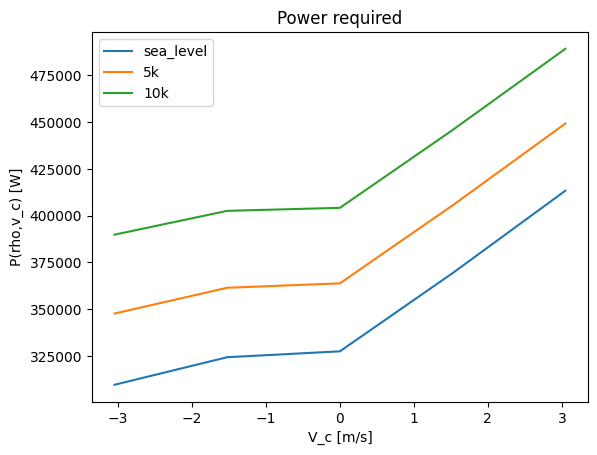

In [3]:
power_dict = {}
power_dict['sea_level'] = [PowerClimb(i,density_sea_level) for i in velocity_climb_list]
power_dict['5k'] = [PowerClimb(i,density_5k_ft) for i in velocity_climb_list]
power_dict['10k'] = [PowerClimb(i,density_10k_ft) for i in velocity_climb_list]
display(pd.DataFrame(power_dict))
for i in power_dict.keys():
  plt.plot(velocity_climb_list,power_dict[str(i)],label=i)
plt.title('Power required')
plt.xlabel('V_c [m/s]')
plt.ylabel('P(rho,v_c) [W]')
plt.legend()
plt.show()

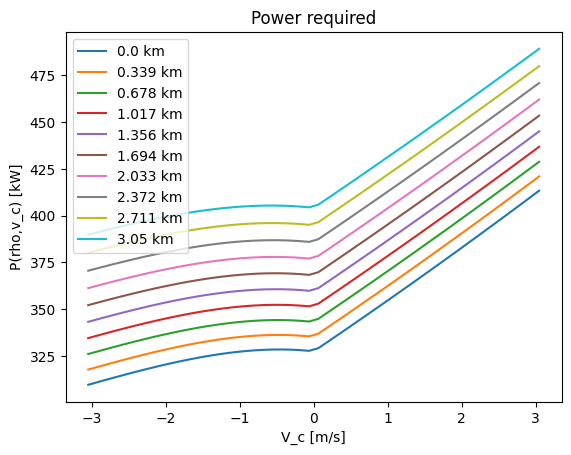

In [4]:
# making smoother curves
power_function_dict = {}
for altitude in np.linspace(0, 10000*ft2km, 10):
  power_function_dict[str(altitude)] = [PowerClimb(velocity,edm.Density(altitude))*10**-3 for velocity in np.linspace(velocity_climb_list[0],velocity_climb_list[-1],50)]
for i in power_function_dict.keys():
  plt.plot(np.linspace(velocity_climb_list[0],velocity_climb_list[-1],50),power_function_dict[i],label=f'{(round(float(i),3))} km')
plt.title('Power required')
plt.xlabel('V_c [m/s]')
plt.ylabel('P(rho,v_c) [kW]')
plt.legend()
plt.show()

### 2)
Using the same helicopter to for finding induced flow

In [5]:
lambda_i, mu, alpha, C_T = sp.symbols('\\lambda_i, \\mu, \\alpha, C_T')
objective_symbolic = mu*sp.tan(alpha) + C_T / (2*(mu**2+lambda_i**2)**0.5) - lambda_i
display(objective_symbolic)
objective_symbolic_prime = objective_symbolic.diff(lambda_i)
objective_symbolic_doubleprime = objective_symbolic.diff(lambda_i,2)
display(objective_symbolic_prime)
display(objective_symbolic_doubleprime)
coefficient_thrust = 0.01
velocity_tip = lambda rho: (thrust_req/(rho*rotor_area*coefficient_thrust))**0.5
displayVariableWithUnits('\\Omega{R}',velocity_tip(density_sea_level),'\\frac{m}{s}')
def AdvanceRatio(
  rotor_tip_velocity:float,
  freestream_velocity:float,
  angle_of_attack:float
)->float:
  v_tip = rotor_tip_velocity
  v_infty = freestream_velocity
  alpha = angle_of_attack
  mu = v_infty * np.cos(alpha) / v_tip
  return mu
mu_sea_level = AdvanceRatio(velocity_tip(density_sea_level),VelocityHover(density_sea_level)*10,0)
alef = np.array([-0.5 * mu_sea_level**2 + 0.5*(mu_sea_level**4 + coefficient_thrust**2)**0.5,
                -0.5 * mu_sea_level**2 - 0.5*(mu_sea_level**4 + coefficient_thrust**2)**0.5])
displayVariable('\\alef',alef)
inflow_zero = np.array([
  np.emath.sqrt(alef),
  -np.emath.sqrt(alef)
])
displayVariable('\\lambda_0',inflow_zero)
for i in inflow_zero.real:
  if i[0] > 0.0:
    displayVariable('\\lambda_{\\alpha=0}',i[0])

C_T/(2*(\lambda_i**2 + \mu**2)**0.5) - \lambda_i + \mu*tan(\alpha)

-0.5*C_T*\lambda_i/(\lambda_i**2 + \mu**2)**1.5 - 1

C_T*(1.5*\lambda_i**2/(\lambda_i**2 + \mu**2)**2.5 - 0.5/(\lambda_i**2 + \mu**2)**1.5)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
ObjectiveFunction = lambdify((lambda_i,mu,alpha,C_T),objective_symbolic,'numpy')
ObjectiveFunction_prime = lambdify((lambda_i,mu,alpha,C_T),objective_symbolic_prime,'numpy')
ObjectiveFunction_doubleprime = lambdify((lambda_i,mu,alpha,C_T),objective_symbolic_doubleprime,'numpy')
inflow_0 = np.sqrt(coefficient_thrust / 2)
tolerance = 1e-12
max_iteration_count = 300
def FixedPoint(inflow_ratio,angle_of_attack,advanvce_ratio):
  mu = advanvce_ratio
  alpha = angle_of_attack
  lambda_i = inflow_ratio
  C_T_given = coefficient_thrust
  fixed_point_dict = {
    'error_i':[],
    'lambda_i':[],
    'step' : [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)) > tolerance and iteration_count < max_iteration_count:
    iteration_count += 1
    fixed_point_dict['error_i'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
    fixed_point_dict['lambda_i'].append(lambda_i)
    fixed_point_dict['step'].append(ObjectiveFunction(lambda_i,mu,alpha,C_T_given))
    lambda_i = lambda_i + ObjectiveFunction(lambda_i,mu,alpha,C_T_given)
    fixed_point_dict['lambda_i+1'].append(lambda_i)
    fixed_point_dict['error_i+1'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
  return fixed_point_dict
def NewtonRaphson(inflow_ratio,angle_of_attack,advanvce_ratio):
  mu = advanvce_ratio
  alpha = angle_of_attack
  lambda_i = inflow_ratio
  C_T_given = coefficient_thrust
  newton_raphson_dict = {
    'error_i':[],
    'lambda_i':[],
    'step': [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)) > tolerance and iteration_count < max_iteration_count:
    iteration_count += 1
    newton_raphson_dict['error_i'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
    newton_raphson_dict['lambda_i'].append(lambda_i)
    newton_raphson_dict['step'].append(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)/ObjectiveFunction_prime(lambda_i,mu,alpha,C_T_given))
    lambda_i = lambda_i - ObjectiveFunction(lambda_i,mu,alpha,C_T_given)/ObjectiveFunction_prime(lambda_i,mu,alpha,C_T_given)
    newton_raphson_dict['lambda_i+1'].append(lambda_i)
    newton_raphson_dict['error_i+1'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
  return newton_raphson_dict
def HalleysMethod(inflow_ratio,angle_of_attack,advanvce_ratio):
  mu = advanvce_ratio
  alpha = angle_of_attack
  lambda_i = inflow_ratio
  C_T_given = coefficient_thrust
  halley_dict = {
    'error_i':[],
    'lambda_i':[],
    'step': [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)) > tolerance and iteration_count < max_iteration_count:
    iteration_count += 1
    halley_dict['error_i'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
    halley_dict['lambda_i'].append(lambda_i)
    f = ObjectiveFunction(lambda_i,mu,alpha,C_T_given)
    f_prime = ObjectiveFunction_prime(lambda_i,mu,alpha,C_T_given)
    f_doubleprime = ObjectiveFunction_doubleprime(lambda_i,mu,alpha,C_T_given)
    try:
      step_size = 2*f / (f_prime - np.emath.sqrt((f_prime**2 -f*f_doubleprime)).real)
    except RuntimeError:
      step_size = f/f_prime
    halley_dict['step'].append(step_size)
    lambda_i = lambda_i - step_size
    halley_dict['lambda_i+1'].append(lambda_i)
    halley_dict['error_i+1'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
  return halley_dict
for i in inflow_zero.real:
  if i[0] > 0.0:
    displayVariable('\\lambda_{\\alpha=0}',i[0])
displayVariable('\\lambda_{i=0}',inflow_0)
print('Fixed Point iterations')
start_time = time.time()
display(pd.DataFrame(FixedPoint(inflow_0,0,mu_sea_level)))
displayVariable('\\lambda_{FP}',FixedPoint(inflow_0,0,mu_sea_level)['lambda_i+1'][-1])
end_time = time.time()
print(f"Took {end_time-start_time:.5f} seconds to run")
print('Newton-Raphson iterations')
start_time = time.time()
display(pd.DataFrame(NewtonRaphson(inflow_0,0,mu_sea_level)))
displayVariable('\\lambda_{NR}',NewtonRaphson(inflow_0,0,mu_sea_level)['lambda_i+1'][-1])
end_time = time.time()
print(f"Took {end_time-start_time:.5f} seconds to run")
print('Halley\'s Method iterations')
start_time = time.time()
display(pd.DataFrame(HalleysMethod(inflow_0,0,mu_sea_level)))
displayVariable('\\lambda_{HM}',HalleysMethod(inflow_0,0,mu_sea_level)['lambda_i+1'][-1])
end_time = time.time()
print(f"Took {end_time-start_time:.5f} seconds to run")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Fixed Point iterations


,error_i,lambda_i,step,lambda_i+1,error_i+1
0,6.367470e-02,0.070711,-6.367470e-02,0.007036,3.474234e-05
1,3.474234e-05,0.007036,3.474234e-05,0.007071,3.465010e-09
2,3.465010e-09,0.007071,-3.465010e-09,0.007071,3.464321e-13


<IPython.core.display.Math object>

Took 0.01593 seconds to run
Newton-Raphson iterations


,error_i,lambda_i,step,lambda_i+1,error_i+1
0,6.367470e-02,0.070711,6.361203e-02,0.007099,2.793357e-05
1,2.793357e-05,0.007099,2.793076e-05,0.007071,5.513840e-12
2,5.513840e-12,0.007071,5.513289e-12,0.007071,8.673617e-19


<IPython.core.display.Math object>

Took 0.01618 seconds to run
Halley's Method iterations


,error_i,lambda_i,step,lambda_i+1,error_i+1
0,0.063675,0.070711,0.063626,0.007085,1.426388e-05
1,0.000014,0.007085,0.000014,0.007071,7.188651e-13


<IPython.core.display.Math object>

Took 0.01704 seconds to run


Took 0.00714 seconds to run analytical solution
Took 0.25602 seconds to run FP solution
Took 0.06678 seconds to run NR solution
Took 0.10827 seconds to run Halley's solution


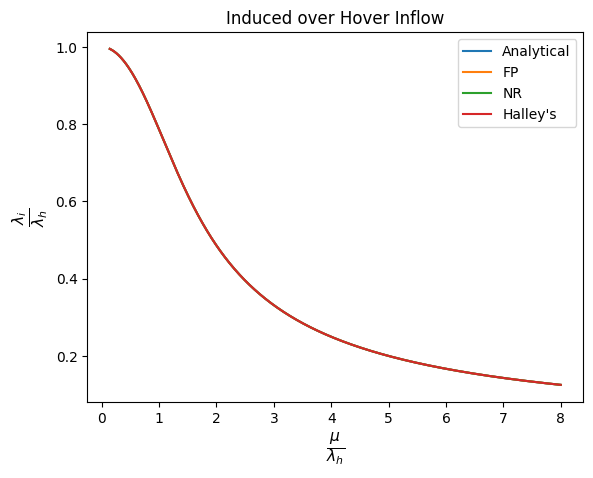

In [7]:
### analytical inflow ratio
inflow_hover = np.sqrt(coefficient_thrust/2)
def AnalyticalInflowRatio(advance_ratio,inflow_hover):
  variable_ratio = advance_ratio/inflow_hover
  return np.sqrt(-0.5*variable_ratio**2 + np.sqrt(0.25*variable_ratio**4 + 1))
advance_ratio_values = np.linspace(0.01,inflow_hover*8,1000)
start_time = time.time()
analytical_inflow_ratio_values = [AnalyticalInflowRatio(float(i),inflow_hover) for i in advance_ratio_values]
end_time = time.time()
analytical_runtime = end_time-start_time
print(f"Took {end_time-start_time:.5f} seconds to run analytical solution")
start_time = time.time()
fixed_point_inflow_ratio_values = [FixedPoint(inflow_0,0,float(i))['lambda_i+1'][-1]/inflow_hover for i in advance_ratio_values]
end_time = time.time()
fixed_point_runtime = end_time-start_time
print(f"Took {end_time-start_time:.5f} seconds to run FP solution")
start_time = time.time()
newton_raphson_inflow_ratio_values = [NewtonRaphson(inflow_0,0,float(i))['lambda_i+1'][-1]/inflow_hover for i in advance_ratio_values]
end_time = time.time()
newton_raphson_runtime = end_time-start_time
print(f"Took {end_time-start_time:.5f} seconds to run NR solution")
start_time = time.time()
halley_inflow_ratio_values = [HalleysMethod(inflow_0,0,float(i))['lambda_i+1'][-1]/inflow_hover for i in advance_ratio_values]
end_time = time.time()
halley_runtime = end_time-start_time
print(f"Took {end_time-start_time:.5f} seconds to run Halley\'s solution")



# plotting
input_ratio = advance_ratio_values/inflow_hover
plt.plot(input_ratio,analytical_inflow_ratio_values,label='Analytical')
plt.plot(input_ratio,fixed_point_inflow_ratio_values,label='FP')
plt.plot(input_ratio,newton_raphson_inflow_ratio_values,label='NR')
plt.plot(input_ratio,halley_inflow_ratio_values,label='Halley\'s')
plt.legend()
plt.title('Induced over Hover Inflow')
plt.xlabel(r'$ \frac{\mu}{\lambda_h} $',fontsize=16)
plt.ylabel(r'$ \frac{\lambda_i}{\lambda_h} $',fontsize=16)
plt.show()

# runtimes = [analytical_runtime,fixed_point_runtime,newton_raphson_runtime,halley_runtime]
# plt.hist(runtimes[1:],bins=3,edgecolor='black')
# plt.show()

In [8]:
def DoAllOfQuestion3(inital_inflow_guess):
  angle_of_attack_values = range(-4,9,2)
  start_time = time.time()
  fixed_point_func_mu = {}
  num_of_iterations_FP = []
  num_of_iterations_NR = []
  num_of_iterations_HM = []
  for alpha in angle_of_attack_values:
    fixed_point_func_mu[f'{alpha}'] =  [(FixedPoint(inital_inflow_guess,alpha*deg2rad,mu)['lambda_i+1']) for mu in advance_ratio_values]
    for lambda_i in fixed_point_func_mu[f'{alpha}']:
      num_of_iterations_FP.append(len(lambda_i))
  end_time = time.time()
  fixed_point_runtime = end_time - start_time
  print(f"Took {end_time-start_time:.5f} seconds to run FP solution")
  print(f"Average Rate of Convergence: {round(np.mean(num_of_iterations_FP),4)}")
  start_time = time.time()
  newton_raphson_func_mu = {}
  for alpha in angle_of_attack_values:
    newton_raphson_func_mu[f'{alpha}'] =  [(NewtonRaphson(inital_inflow_guess,alpha*deg2rad,mu)['lambda_i+1']) for mu in advance_ratio_values]
    for lambda_i in newton_raphson_func_mu[f'{alpha}']:
      num_of_iterations_NR.append(len(lambda_i))
  end_time = time.time()
  newton_runtime = end_time - start_time
  print(f"Took {end_time-start_time:.5f} seconds to run NR solution")
  print(f"Average Rate of Convergence: {round(np.mean(num_of_iterations_NR),4)}")
  halley_func_mu = {}
  for alpha in angle_of_attack_values:
    halley_func_mu[f'{alpha}'] =  [(HalleysMethod(inital_inflow_guess,alpha*deg2rad,mu)['lambda_i+1']) for mu in advance_ratio_values]
    for lambda_i in halley_func_mu[f'{alpha}']:
      num_of_iterations_HM.append(len(lambda_i))
  end_time = time.time()
  halley_runtime = end_time - start_time
  print(f"Took {end_time-start_time:.5f} seconds to run Halley solution")
  print(f"Average Rate of Convergence: {round(np.mean(num_of_iterations_HM),4)}")
  # Plotting  
  fig,axis = plt.subplots(int(len(angle_of_attack_values)/2+1),2, figsize=(10,8))
  axis[0,0].set_title(r'$ \alpha= -4 $')
  axis[0,0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['-4']],label='FP')
  axis[0,0].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['-4']],label='NR')
  axis[0,0].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['-4']],label='HM')
  axis[0,0].legend()
  axis[0,0].set_ylabel(r'$ \lambda_i $')
  axis[0,0].set_xlabel(r'$ \mu $')

  axis[0,1].set_title(r'$ \alpha= -2 $')
  axis[0,1].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['-2']],label='FP')
  axis[0,1].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['-2']],label='NR')
  axis[0,1].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['-2']],label='HM')
  axis[0,1].legend()
  axis[0,1].set_ylabel(r'$ \lambda_i $')
  axis[0,1].set_xlabel(r'$ \mu $')

  axis[1,0].set_title(r'$ \alpha= 0 $')
  axis[1,0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['0']],label='FP')
  axis[1,0].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['0']],label='NR')
  axis[1,0].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['0']],label='HM')
  axis[1,0].legend()
  axis[1,0].set_ylabel(r'$ \lambda_i $')
  axis[1,0].set_xlabel(r'$ \mu $')

  axis[1,1].set_title(r'$ \alpha= 2 $')
  axis[1,1].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['2']],label='FP')
  axis[1,1].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['2']],label='NR')
  axis[1,1].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['2']],label='HM')
  axis[1,1].legend()
  axis[1,1].set_ylabel(r'$ \lambda_i $')
  axis[1,1].set_xlabel(r'$ \mu $')

  axis[2,0].set_title(r'$ \alpha= 4 $')
  axis[2,0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['4']],label='FP')
  axis[2,0].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['4']],label='NR')
  axis[2,0].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['4']],label='HM')
  axis[2,0].legend()
  axis[2,0].set_ylabel(r'$ \lambda_i $')
  axis[2,0].set_xlabel(r'$ \mu $')

  axis[2,1].set_title(r'$ \alpha= 6 $')
  axis[2,1].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['6']],label='FP')
  axis[2,1].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['6']],label='NR')
  axis[2,1].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['6']],label='HM')
  axis[2,1].legend()
  axis[2,1].set_ylabel(r'$ \lambda_i $')
  axis[2,1].set_xlabel(r'$ \mu $')

  axis[3,0].set_title(r'$ \alpha= 8 $')
  axis[3,0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['8']],label='FP')
  axis[3,0].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['8']],label='NR')
  axis[3,0].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['8']],label='HM')
  axis[3,0].legend()
  axis[3,0].set_ylabel(r'$ \lambda_i $')
  axis[3,0].set_xlabel(r'$ \mu $')

  axis[3,1].set_title('Convergence NR v HM')
  axis[3,1].plot(np.arange(0,len(num_of_iterations_NR)),num_of_iterations_NR,label='NR')
  axis[3,1].plot(np.arange(0,len(num_of_iterations_HM)),num_of_iterations_HM,label='HM')
  axis[3,1].legend()
  axis[3,1].set_xlabel(r'$ \beta $')
  axis[3,1].set_ylabel(r'$ iterations $')

  fig.suptitle(r'$ \lambda_0  =$' + f'{round(inital_inflow_guess,4)}')
  plt.tight_layout()
  plt.show()
  
  fig2,axis2 = plt.subplots(3,1,figsize=(8,10))
  for alpha in angle_of_attack_values:
    axis2[0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu[f'{alpha}']],label=f'{alpha}')
    axis2[1].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu[f'{alpha}']],label=f'{alpha}')
    axis2[2].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu[f'{alpha}']],label=f'{alpha}')
  axis2[0].set_title('Fixed Point')
  axis2[0].legend()
  axis2[0].set_ylabel(r'$ \lambda_i $')
  axis2[0].set_xlabel(r'$ \mu $')
  axis2[1].set_title('Newton Raphson')
  axis2[1].legend()
  axis2[1].set_ylabel(r'$ \lambda_i $')
  axis2[1].set_xlabel(r'$ \mu $')
  axis2[2].set_title('Halley Method')
  axis2[2].legend()
  axis2[2].set_ylabel(r'$ \lambda_i $')
  axis2[2].set_xlabel(r'$ \mu $')
  plt.tight_layout(h_pad=1.0)
  plt.show()
  
  return None

In [ ]:
DoAllOfQuestion3(inflow_hover)

In [ ]:
scaling_factor = 3
inital_inflow_guess_values = np.linspace(-scaling_factor*inflow_hover,scaling_factor*inflow_hover,6)
for i in inital_inflow_guess_values:
  DoAllOfQuestion3(i)

In [ ]:
mu_4 = mu_sea_level
def AnalyticalInducedOverHover(climb_over_hover):
  kappa = 1
  k1,k2,k3,k4 = -1.125,-1.372,-1.718,-0.655
  return kappa + k1*climb_over_hover + k2*climb_over_hover**2 + k3*climb_over_hover**3 + k4*climb_over_hover**4
def ObjectiveFunctionInducedWithClimb(
  inflow_ratio:float,
  advancing_ratio:float,
  angle_of_attack:float,
  climb_ratio:float
): 
  C_T = coefficient_thrust
  lambda_i = inflow_ratio
  mu = advancing_ratio
  alpha = angle_of_attack
  lambda_c = climb_ratio
  return mu*np.tan(alpha) + C_T/(2*np.sqrt(mu**2+lambda_i**2))+lambda_c*np.cos(alpha)
def InflowClimb(climb_over_hover):
  velocity_climb = climb_over_hover*VelocityHover(edm.Density(0))
  return velocity_climb/velocity_tip
def PowerOverHover(climb_over_hover):
  return NotImplementedError